# Modelling Energy Potential Predictions
---
In this notebook, I will predict energy potential for Spain using various models. 

**Contents:**
- [Import libraries and data](#Import-libraries-and-data)
- [Preprocess](#Preprocessing)
- [Evaluation Metric](#Evaluation-Metric)
- [Baseline Model](#Baseline-Model)
- [Model Selection](#Model-Selection)
- [Modelling with fbprophet](#Modelling-with-fbprophet)
- [References](#References)

### Import libraries and data
---

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('seaborn-white')
import seaborn as sns
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import time
#modelling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import sys
!{sys.executable} -m pip install fbprophet
from fbprophet import Prophet
# import itertools
# from prophet.diagnostics import cross_validation, performance_metrics

In [2]:
#read country csv file
spain_ep_ctry = pd.read_csv('../data/spain-energy-potential-country.csv')
#preview 
print(' Top 5 rows '.center(50,'-'))
display(spain_ep_ctry.head())
print(f'Shape of data : {spain_ep_ctry.shape}')
print(' Data types '.center(50,'-'))
print(spain_ep_ctry.dtypes)

------------------- Top 5 rows -------------------


,Spain,time,year,week_of_year,day_of_year,hour
0,0.0,2006-01-03 00:00:00,2006,1,3,0
1,0.0,2006-01-03 01:00:00,2006,1,3,1
2,0.0,2006-01-03 02:00:00,2006,1,3,2
3,0.0,2006-01-03 03:00:00,2006,1,3,3
4,0.0,2006-01-03 04:00:00,2006,1,3,4


Shape of data : (87600, 6)
------------------- Data types -------------------
Spain           float64
time             object
year              int64
week_of_year      int64
day_of_year       int64
hour              int64
dtype: object


In [3]:
#convert time to datetime
spain_ep_ctry['time'] = pd.to_datetime(spain_ep_ctry['time'])
#check
spain_ep_ctry.dtypes

Spain                  float64
time            datetime64[ns]
year                     int64
week_of_year             int64
day_of_year              int64
hour                     int64
dtype: object

### Preprocessing
---
To ensure a consistent number of data for each year, I will remove leap years from the period 2006 to 2015, specifically 2008 and 2012. 

In [4]:
#remove leap years
spain_ep_ctry = spain_ep_ctry[(spain_ep_ctry['year']!=2008)&(spain_ep_ctry['year']!=2012)]
#check
spain_ep_ctry.year.unique()

array([2006, 2007, 2009, 2010, 2011, 2013, 2014, 2015], dtype=int64)

In [5]:
#train-test-split, set out the last month for predictions (12-2015)
train = spain_ep_ctry[-24*365*10:-24*31]
test = spain_ep_ctry[-24*31:]

The test set will be the holdout set and will only be used to obtain predictions at the last stage. 

In [6]:
#create features and target variable
X_train, y_train = train.drop(columns=['Spain','time'], axis=1), train['Spain']
X_test, y_test = test.drop(columns=['Spain','time'], axis=1), test['Spain']

### Evaluation Metric
---
The Root Mean Squared Error(RMSE) and Mean Absolute Error (MAE) will be used to evaluate the best and reliable model. 

**RMSE**

RMSE is the root of average of the total squared forecast error values. The mean squared error penalizes larger errors so when root is applied, it transforms the value back into the original units of the predictions. 

When comparing between models, we'd want the RMSE to be as low as possible which mean lesser difference in values between actual and forecasted energy potential. 

**MAE**

MAE is the average magnitude of the errors in a set of predictions, without considering direction (ie. average over the test sample of absolute differences between prediction and actual observation where all individual differences have equal weight.

Similarly, a better model would have lower mean absolute errors. 

In [7]:
# create a function that computes rmse
def rmse(y_true, y_pred):
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),4)
    return rmse

In [8]:
# create a function that computes mae
def mae(y_true, y_pred):
    mae = round(mean_absolute_error(y_true, y_pred),4)
    return mae

### Baseline Model
---
I first set a baseline model, from which I can gauge how good my production model performs. In predicting energy potential, the most basic estimate is the hourly mean of all predictions made for the year. 

In [11]:
#function that computes hourly mean
def hourly_mean(day, hour):
    mean = train[(train['day_of_year']==day) & (train['hour']==hour)]['Spain'].mean()
    return mean

In [12]:
#get predictions
X_train['pred'] = X_train.apply(lambda x: hourly_mean(x.day_of_year, x.hour), axis=1)
X_test['pred'] = X_test.apply(lambda x: hourly_mean(x.day_of_year, x.hour), axis=1)

In [13]:
#evaluate model with rmse and put into a table 
results_train = PrettyTable(title = "Results of Forecasting Models on Train Set", header_style = 'title', max_table_width = 130)
results_train.field_names = ["Model", "RMSE", "MAE"]

# function that adds models and scores to rows in table
def add_to_table_baseline(model, y_train_true, y_train_pred):
    rmse_train = rmse(y_train_true, y_train_pred)
    mae_train = mae(y_train_true, y_train_pred)
    results_train.add_row([model, rmse_train, mae_train])

#add baseline model to table.
add_to_table_baseline("Baseline", y_train, X_train['pred'])

#view current table
print(results_train)

+------------------------------------------+
| Results of Forecasting Models on Train Set |
+----------------+------------+------------+
|     Model      |    Rmse    |    Mae     |
+----------------+------------+------------+
|    Baseline    |   0.0524   |   0.0258   |
+----------------+------------+------------+


In [14]:
#function that plots prediction on test set
def predictions_viz(y_true_series, y_pred_series, title):
    plt.figure(figsize=(20,8))
    df = pd.concat([y_true_series, y_pred_series],axis=1)
    sns.lineplot(data=df, palette='inferno_r')
    plt.title(title, fontsize=16)
    plt.xlabel("December 2015 (hours)", fontsize=14)
    plt.xticks([])
    plt.ylabel("Energy potential (%)", fontsize=14)
    plt.legend(labels=['true values', 'predictions'], fontsize=14)
    plt.show()

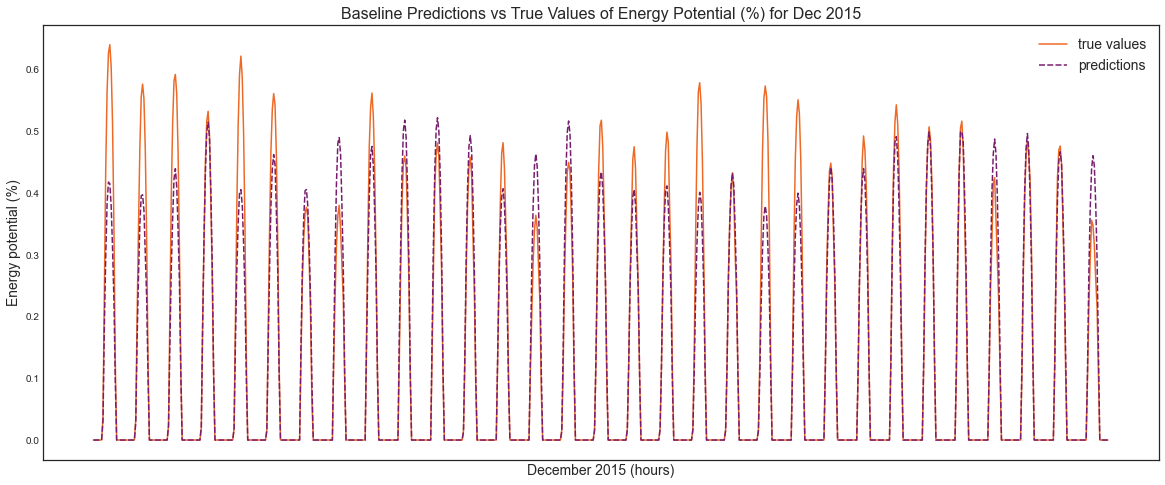

In [15]:
predictions_viz(test['Spain'],X_test['pred'], "Baseline Predictions vs True Values of Energy Potential (%) for Dec 2015")

From above, we see that the predictions also move cyclically, expected with seasonality of energy potential. There are some significant differences between the true values and predictions. 

We will attempt to create more accurate predictions with more complex models below. 

### Model Selection
A range of models are selected and fitted to train, and predict on the test set. 

In [16]:
#instantiate regressors
lr = LinearRegression()
rfr = RandomForestRegressor()
knnr = KNeighborsRegressor()
xgbr = xgb.XGBRegressor()

In [17]:
# set pipeline
lr_p = Pipeline([('ss', StandardScaler()),
                ('lr', lr)])
rfr_p = Pipeline([('rfr', rfr)])
knnr_p = Pipeline([('ss', StandardScaler()),
                  ('knnr', knnr)])
xgbr_p = Pipeline([('xgbr', xgbr)])

In [18]:
#set up params
lr_params = [{}]

rfr_params = [{'rfr__n_estimators':[200,350,500],
               'rfr__max_depth':[2,5,10],
               'rfr__min_samples_split':[12,15,20]}]

knnr_params = [{'knnr__leaf_size':[20,30,50],
               'knnr__n_neighbors':[2,5,10]}]

xgbr_params = [{'xgbr__n_estimators':[70,150,250],
                'xgbr__max_depth':[3,5,7],
                'xgbr__learning_rate':[0.01,0.05,0.5,0.1]}]

In [19]:
#instantiate gridsearch
gridcvs = {}
tscv = TimeSeriesSplit(n_splits=5)

for paramgrid, estimator, name in zip((lr_params,rfr_params,knnr_params,xgbr_params),
                                     (lr_p,rfr_p,knnr_p,xgbr_p),
                                     ("Linear Regression","Random Forest","K Neighbors","XGB")):
    gcv = GridSearchCV(estimator = estimator,
                      param_grid = paramgrid,
                      scoring = 'neg_root_mean_squared_error',
                      n_jobs = 2,
                      cv = tscv,
                      verbose = 0,
                      refit = True)
    gridcvs[name] = gcv

In [20]:
%%time
#run grid search
for name, gs_est in gridcvs.items():
    start = time.time()
    rmse_train_cv = -round(cross_val_score(gs_est,
                                          X = X_train,
                                          y = y_train,
                                          cv = tscv,
                                          scoring = 'neg_root_mean_squared_error',
                                          n_jobs=2).mean(),4)

    mae_train_cv = -round(cross_val_score(gs_est,
                                          X = X_train,
                                          y = y_train,
                                          cv = tscv,
                                          scoring = 'neg_mean_absolute_error',
                                          n_jobs=2).mean(),4)
    
    results_train.add_row([name,rmse_train_cv,mae_train_cv])
    end = time.time()
    time_taken_mins = round((end-start)/60, 2)
    print(f'Updated {name} into results table! It took {time_taken_mins} minutes.')

Updated Linear Regression into results table! It took 0.03 minutes.
Updated Random Forest into results table! It took 20.08 minutes.
Updated K Neighbors into results table! It took 0.21 minutes.
Updated XGB into results table! It took 4.24 minutes.
Wall time: 24min 34s


In [21]:
#view results table
print(results_train)

+----------------------------------------------+
|  Results of Forecasting Models on Train Set  |
+------------------------+----------+----------+
|         Model          |   Rmse   |   Mae    |
+------------------------+----------+----------+
|        Baseline        |  0.0524  |  0.0258  |
|   Linear Regression    |  0.0532  |  0.0283  |
|     Random Forest      |  0.0542  |  0.0268  |
|      K Neighbors       |  0.0622  |  0.0313  |
|          XGB           |  0.0554  |  0.0346  |
+------------------------+----------+----------+


#### Observations

1. None of the models did better than baseline. The closest is linear regression. It could be that other models are too complex for forecasting with just few features, such that linear regression did the best. It is also likely that these regressors are not suitable for forecasting or recognising seasonality. 


2. In view of the above, more forecast ingmethods and libraries can be explored to try and achive a  better model.

### Modelling with fbprophet
Since tree regressors do not work better than the baseline, I decided to use this powerful library, `fbprophet`.

In [22]:
#prep historical dataframe for prophet
historical_train = train[['Spain','time']]
historical_train.rename(columns={'time':'ds',
                                'Spain':'y'}, inplace=True)

In [23]:
#instantiate and fit
prophet = Prophet(daily_seasonality = False, #none noted from exploration notebook
                  weekly_seasonality = False, #to include fourier, 15 
                  yearly_seasonality = False,
                  seasonality_mode = 'additive', #season's effects amplified at time goes on
                  changepoint_prior_scale = 0.5, #adjust strength of variability. lower, less flexible
                  seasonality_prior_scale = 1, #controls flexibility of seasonality
                  changepoint_range = 0.8) #how much of training data should fbprophet learn changepoints 

prophet.add_seasonality(name='daily', period=24, fourier_order=100) 
prophet.add_seasonality(name='yearly', period=365, fourier_order=100) 

prophet.fit(historical_train)

In [24]:
#prep future range to predict
future = prophet.make_future_dataframe(periods=744, freq='H') #number of hours in dec 2015

In [25]:
#forecast energy potential
forecast = prophet.predict(future)

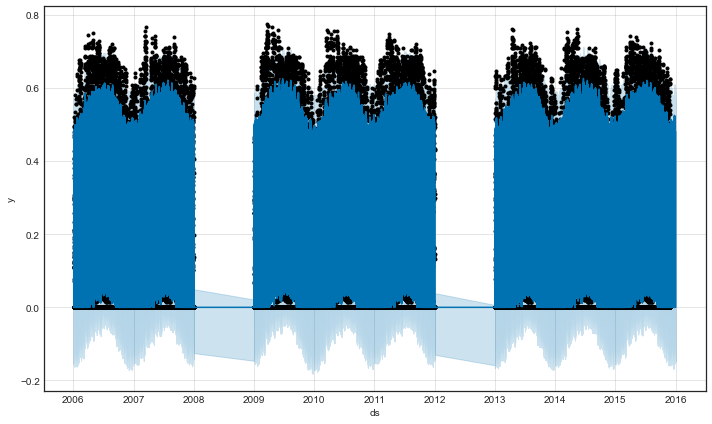

In [26]:
#replace negative values with 0 
forecast.loc[forecast['yhat']<0, 'yhat']=0
#plot forecast
forecast_viz = prophet.plot(forecast)

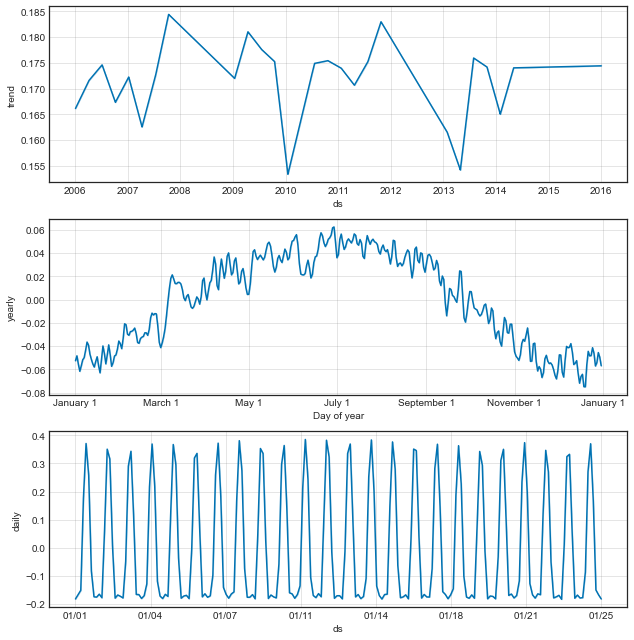

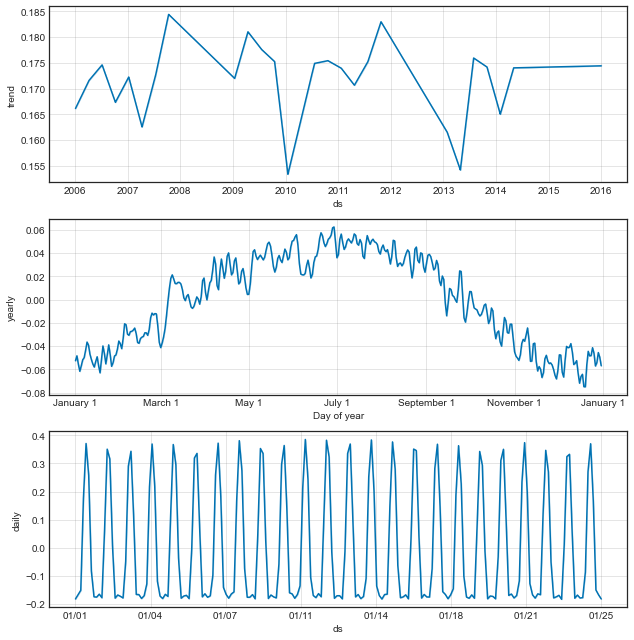

In [27]:
#view trends across different time frames
prophet.plot_components(forecast)

In [28]:
#put predictions in dataframe
preds = forecast[['ds','yhat']][-24*31:]
#make ds the index
preds = preds.set_index(['ds'])

In [29]:
#visualise
test_viz = test.set_index(['time'])

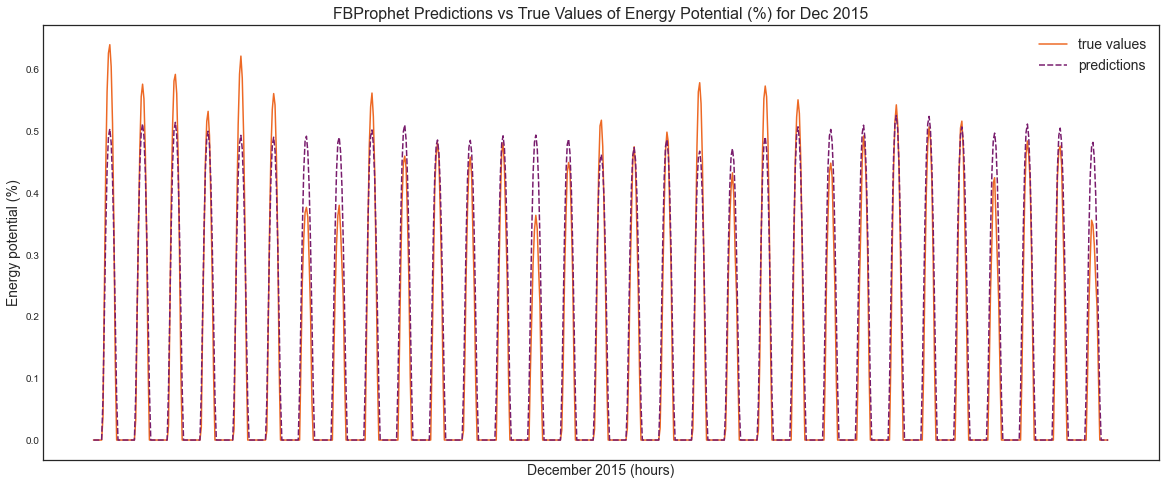

In [30]:
predictions_viz(test_viz['Spain'],preds['yhat'], "FBProphet Predictions vs True Values of Energy Potential (%) for Dec 2015")

It appears that fbprophet did not do significantly well on this data. Althought it is able to recognise seasonality. 

In [31]:
#add fbprophet results into table 
rmse_train_fbp = rmse(test_viz['Spain'], preds['yhat'])
mae_train_fbp = mae(test_viz['Spain'], preds['yhat'])
#add to results table
results_train.add_row(["FB Prophet",rmse_train_fbp,mae_train_fbp])

In [32]:
print(results_train)

+----------------------------------------------+
|  Results of Forecasting Models on Train Set  |
+------------------------+----------+----------+
|         Model          |   Rmse   |   Mae    |
+------------------------+----------+----------+
|        Baseline        |  0.0524  |  0.0258  |
|   Linear Regression    |  0.0532  |  0.0283  |
|     Random Forest      |  0.0542  |  0.0268  |
|      K Neighbors       |  0.0622  |  0.0313  |
|          XGB           |  0.0554  |  0.0346  |
|       FB Prophet       |  0.0491  |  0.0293  |
+------------------------+----------+----------+


In [34]:
#save out results into a text file
store_results = results_train.get_string()
with open('../data/results_train.txt','w') as f:
    f.write(store_results)

FB prophet did better than other models, achieving the lowest errors. In [this notebook](05-modelling-neural-nets.ipynb), I attempt to predict using Neural Networks. 

### References

MAE vs RMSE

https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

FBPROPHET

https://facebook.github.io/prophet
https://facebook.github.io/prophet/docs/diagnostics.html

multiplicative explanation 

https://facebook.github.io/prophet/docs/multiplicative_seasonality.html

changepoint prior scale 

https://facebook.github.io/prophet/docs/trend_changepoints.html

changepoint range - default is changepoint inferred for the first 80% of the time series. 

seasonality prior scale

https://facebook.github.io/prophet/docs/diagnostics.html
